<a href="https://colab.research.google.com/github/MiHarsh/Pytorch_Fanatics/blob/main/age_detection_using_pytorch_fanatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7931d1b7-8cd4-e951-f60a-451c552bdbab)


**Requests are used to get Datasets from a given Link.So we dont need to download it locally and Upload**

In [2]:
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
download_url('https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip','/content/train.zip')

!unzip -qq train.zip
!rm -r train.zip

In [3]:
# ==== Install Dependencies

!pip install -q timm
!pip install -q albumentations
!pip install -q pytorch-fanatics 
!pip install -q pytorch_ranger

     |████████████████████████████████| 245kB 7.7MB/s 
     |████████████████████████████████| 634kB 8.6MB/s 


In [4]:
# ==== Import Libraries

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
import random
import os


import albumentations as aug
from albumentations.pytorch.transforms import ToTensor
import matplotlib.pyplot as plt

import timm
from tqdm import tqdm

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_fanatics.dataloader import Cloader
from pytorch_fanatics.utils import EarlyStop 
from pytorch_fanatics.trainer import Trainer
from pytorch_fanatics.logger import Logger

import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from pytorch_ranger import Ranger

In [5]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

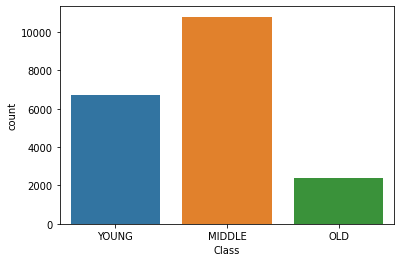

In [6]:
training_data_path = "/content/Train"

df = pd.read_csv('train.csv')
sns.countplot(x = 'Class',data = df, order=['YOUNG','MIDDLE','OLD'])

df['Class'] = df['Class'].map({"YOUNG":0,"MIDDLE":1,"OLD":2})
X_train , X_val ,Y_train , Y_val = tts(df, df.Class.values, test_size=0.25
                                       ,random_state=42,stratify=df.Class.values)
X_train       = X_train.reset_index(drop=True)
X_val         = X_val.reset_index(drop=True)

In [7]:
# ===== Augmentations

mean       = (0.485, 0.456, 0.406)
std        = (0.229, 0.224, 0.225)
train_tfms = aug.Compose([
            aug.Resize(64,64),
            aug.HorizontalFlip(p=0.3),
            aug.RandomBrightnessContrast(0.1,0.1),
            aug.HueSaturationValue(10,10,10),
            aug.RGBShift(),
            aug.RandomContrast(limit=0.2),
            aug.RandomGamma(),
            aug.ShiftScaleRotate(rotate_limit=(-45,45)),
            aug.GaussNoise(p=0.35),
            aug.IAASharpen(),
            aug.ToGray(p=0.35),
            aug.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            ])

test_tfms  = aug.Compose([
            aug.Resize(64,64),
            aug.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            ])

In [8]:
train_images     = X_train.ID.values.tolist()
train_images     = [os.path.join(training_data_path, i) for i in train_images]

test_images      = X_val.ID.values.tolist()
test_images      = [os.path.join(training_data_path, i) for i in test_images]

train_dataset    = Cloader(train_images,X_train.Class.values,None,train_tfms)
test_dataset     = Cloader(test_images,X_val.Class.values,None,test_tfms)

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)
val_dataloader   = DataLoader(test_dataset,batch_size=64,shuffle=False,num_workers=2)

device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

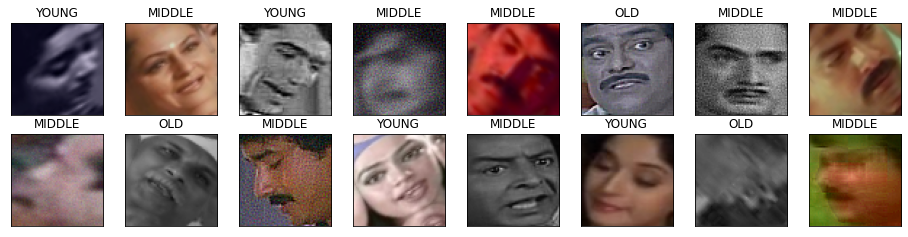

In [9]:
# ===== Visualise few Examples

classes  = ['YOUNG','MIDDLE','OLD']

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
data   = next(iter(train_dataloader))
images = data["image"]
labels = data["targets"]
fig    = plt.figure(figsize=(16,16))
for i in np.arange(16):
    ax = fig.add_subplot(8,8,i+1,xticks=[],yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [10]:
# ===== Define model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.base_model =timm.create_model('efficientnet_b2',pretrained=True,num_classes=3)
    def forward(self, image, targets):
        batch_size, _, _, _ = image.shape
        out = self.base_model(image)
        targets = torch.tensor(targets,dtype=torch.int64)
        loss = nn.CrossEntropyLoss()(out.view(batch_size,3), targets)
        return out, loss

model = Net()
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [11]:
def softmax(array):
    return np.exp(array)/np.sum(np.exp(array),axis=1).reshape(-1,1)

In [12]:
optimizer = Ranger(model.parameters(),lr=5e-3)
scheduler = ReduceLROnPlateau(optimizer,factor=0.8, mode="min", patience=2)

trainer   = Trainer(model=model,optimizer=optimizer,device=device,val_scheduler=scheduler)
logger    = Logger()

es        = EarlyStop(patience=5,mode="min") # mode = min to minimise loss

In [13]:
epochs = 10

for epoch in range(epochs):
    logger.write(f"+ ===== Epoch {epoch+1}/{epochs} ===== +")
    train_loss              = trainer.train(train_dataloader)
    y_true,y_pred ,val_loss = trainer.evaluate(val_dataloader)
    y_pred                  = softmax(y_pred)
    accuracy                = accuracy_score(y_true,np.argmax(y_pred,axis=1))
    es(val_loss,model,model_path ="./best.pth")
    logger.write(f"train_loss {train_loss} val_loss {val_loss} ")
    logger.write(f"val accuracy_score {accuracy} ")
    logger.write(" ")
    if es.early_stop:
        break


+ ===== Epoch 1/10 ===== +



Metric Validation score improved (inf --> 1.072304205252574). Saving model!
train_loss 2.5263438566118226 val_loss 1.072304205252574 
val accuracy_score 0.5933293148483022 
 
+ ===== Epoch 2/10 ===== +



Metric Validation score improved (1.072304205252574 --> 0.7729034817371612). Saving model!
train_loss 0.9302582835030353 val_loss 0.7729034817371612 
val accuracy_score 0.6861563190677115 
 
+ ===== Epoch 3/10 ===== +



Metric Validation score improved (0.7729034817371612 --> 0.6533538320889838). Saving model!
train_loss 0.7854919985064076 val_loss 0.6533538320889838 
val accuracy_score 0.7259393208760297 
 
+ ===== Epoch 4/10 ===== +



Metric Validation score improved (0.6533538320889838 --> 0.6322566419839862). Saving model!
train_loss 0.706811955596646 val_loss 0.6322566419839862 
val accuracy_score 0.7329716696805304 
 
+ ===== Epoch 5/10 ===== +



Metric Validation score improved (0.6322566419839862 --> 0.58451547454565). Saving model!
train_loss 0.6421829381814367 val_loss 0.58451547454565 
val accuracy_score 0.7745629897528632 
 
+ ===== Epoch 6/10 ===== +



Metric Validation score improved (0.58451547454565 --> 0.5075039340135378). Saving model!
train_loss 0.5953108711629851 val_loss 0.5075039340135378 
val accuracy_score 0.796664657424151 
 
+ ===== Epoch 7/10 ===== +



Metric Validation score improved (0.5075039340135378 --> 0.47389814830743354). Saving model!
train_loss 0.5532147767197376 val_loss 0.47389814830743354 
val accuracy_score 0.8147478400642958 
 
+ ===== Epoch 8/10 ===== +



Metric Validation score improved (0.47389814830743354 --> 0.4522212950082925). Saving model!
train_loss 0.516928013445985 val_loss 0.4522212950082925 
val accuracy_score 0.811332127787824 
 
+ ===== Epoch 9/10 ===== +



Metric Validation score improved (0.4522212950082925 --> 0.4365106345369265). Saving model!
train_loss 0.48223328902425927 val_loss 0.4365106345369265 
val accuracy_score 0.8278079164155113 
 
+ ===== Epoch 10/10 ===== +



Metric Validation score improved (0.4365106345369265 --> 0.4300640852023394). Saving model!
train_loss 0.4448447696164122 val_loss 0.4300640852023394 
val accuracy_score 0.8332328712075547 
 
